# 12 - Power‑Law Attenuation Analysis


Unify all RSA metrics (WS, IS‑1, IS‑0, Vision‑Model, plus hemispheric/group splits) under a single latent similarity per parcel.  
We fit:

$$
\rho^{\text{obs}}_{rj}=a_j\bigl(\rho^{\text{latent}}_{r}\bigr)^{\,b_j}+\varepsilon_{rj}
$$

where $a_j\!\in[0,1]$ captures linear attenuation and $b_j\!\ge 1$ captures signal‑dependent (heteroscedastic) noise.  
Eliminating $\rho^{\text{latent}}_r$ predicts pairwise relations between metrics $j,j'$:

$$
y=\frac{a_{j'}}{a_{j}^{\,b_{j'}/b_{j}}}\,x^{\,b_{j'}/b_{j}}
$$

This notebook reproduces Fig. A7 and Fig. A8 (extended relations) in the Supplement A.6.


## 1. Imports

Load plotting/numerical tools and project helpers (surface plots, colorbars, power‑law fitting/plotting).

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Helper functions reused in the project
from convergence.figures import setup_matplotlib_fonts, plot_cbar_set
from convergence.plotting import plot_faverage_parcelation
# These are used in this notebook, but moved to improve the readability of the code
from convergence.power_law_relations import plot_vars, fit_power_ceiling

setup_matplotlib_fonts()

## 2. Data paths

Load NSD RSA tables for:  
- **Intersubject** (shifted / unshifted; joined & split hemispheres; subject‑vs‑group)  
- **Within‑subject**  
- **Vision model** RSA (ViT family, max over layers → mean over models/subjects/sessions)

Also import HCP parcel metadata for labels and surfaces.


In [2]:
data_folder = Path("../derivatives")
nsd_data_folder = data_folder / "nsd"
filename_hcp = data_folder / "metadata" / "hcp.csv"
filename_intersubject_shifted_joined = nsd_data_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
filename_intersubject_shifted_separated = nsd_data_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
filename_intersubject_unshifted_joined = nsd_data_folder / "rsa_subject_subject_alignment_joined_0.parquet"
filename_intersubject_unshifted_separated = nsd_data_folder / "rsa_subject_subject_alignment_separated_0.parquet"
filename_intersubject_shifted_joined_spearman = nsd_data_folder / "rsa_subject_subject_alignment_separated_1_spearman.parquet"
filename_group_shifted_joined_shifted = nsd_data_folder / "rsa_subject_group_alignment_joined_1.parquet"
filename_group_shifted_joined_unshifted = nsd_data_folder / "rsa_subject_group_alignment_joined_0.parquet"
filename_models_joined = nsd_data_folder / "rsa_subject_model_alignment_joined.parquet"

figures_folder = Path("../figures")
output_folder = figures_folder / "12_ceiling_analysis"
output_folder.mkdir(exist_ok=True, parents=True)

## 3. Metric labels

Human‑readable names used throughout figures:

- WS, WS‑lh, WS‑rh  
- IS‑1, IS‑1‑lh, IS‑1‑rh (shift=1)  
- IS‑0, IS‑0‑lh, IS‑0‑rh (unshifted)  
- IS‑group‑0/1 (subject vs. group)  
- V‑M (Vision‑Model)


In [3]:
# Define names for the measures
measure_names = {
    "ws_1": "WS",
    "ws_1_left": "WS-lh",
    "ws_1_right": "WS-rh",
    "is_0": "IS-0",
    "is_0_left": "IS-0-lh",
    "is_0_right": "IS-0-rh",
    "is_1": "IS-1",
    "is_1_left": "IS-1-lh",
    "is_1_right": "IS-1-rh",
    "vision": "V-M",
    "group_0": "IS-group-0",
    "group_1": "IS-group-1",
}

## 4. Aggregation helpers

We average across subject pairs (or subjects/models) to get **one value per ROI per metric**.  
Diagonal only for RSA matrices (roi_x==roi_y). Hemispheres split by `roi<=180` / `>180`.


In [4]:
def aggregate_intersubject(df, query: str):
    df = df.query(query)
    df = df.groupby("roi_x").similarity.mean().reset_index()
    df = df.rename(columns={"roi_x": "roi"})
    return df

## 5. Load & aggregate all metrics

Create individual DataFrames for each metric, then merge into a single wide table:

- `ws_1`, `is_1`, `is_0`, `vision` (core set for the main fit)  
- plus hemispheric/group variants for the extended fit later.

A mask (`df.min(axis=1)>0`) removes parcels with zero/negative values to allow log/power fits.


In [5]:
# Inter-subject and within-subject RSA for shifted data
df = pd.read_parquet(filename_intersubject_shifted_joined)
df_is_1 = aggregate_intersubject(df, "roi_x == roi_y and subject_i != subject_j")
df_ws_1 = aggregate_intersubject(df, "roi_x == roi_y and subject_i == subject_j")

# Intersubject RSA for unshifted data
df = pd.read_parquet(filename_intersubject_unshifted_joined)
df_is_0 = aggregate_intersubject(df, "roi_x == roi_y and subject_i != subject_j")

# Inter-subject and within-subject RSA for shifted data (RSA Spearman)
df = pd.read_parquet(filename_intersubject_shifted_joined_spearman)
df_is_1_spearman = aggregate_intersubject(df, "roi_x == roi_y and subject_i != subject_j")
df_ws_1_spearman = aggregate_intersubject(df, "roi_x != roi_y and subject_i != subject_j")

# Intersubject RSA for unshifted data hemispheres splitted
df = pd.read_parquet(filename_intersubject_unshifted_separated)
df = aggregate_intersubject(df, "roi_x == roi_y and subject_i != subject_j")
df_is_0_left = df.query("roi <=180")
df_is_0_right = df.query("roi > 180")

# Inter-subject RSA for shifted data hemispheres splitted
df = pd.read_parquet(filename_intersubject_shifted_separated)
df = aggregate_intersubject(df, "roi_x == roi_y and subject_i != subject_j")
df_is_1_left = df.query("roi <=180")
df_is_1_right = df.query("roi > 180")

# Within-subject RSA for shifted data hemispheres splitted
df = pd.read_parquet(filename_intersubject_shifted_separated)
df = aggregate_intersubject(df, "roi_x == roi_y and subject_i == subject_j")
df_ws_1_left = df.query("roi <=180")
df_ws_1_right = df.query("roi > 180")

# Inter-subject RSA for group shifted data (leave-one-out group out)
df = pd.read_parquet(filename_group_shifted_joined_shifted)
df_group_1 = aggregate_intersubject(df, "roi_x == roi_y")

# Inter-subject RSA for group unshifted data (leave-one-out group out)
df = pd.read_parquet(filename_group_shifted_joined_unshifted)
df_group_0 = aggregate_intersubject(df, "roi_x == roi_y")

# Load vision models alignments data for include in the comparisons (joined hemispheres)
vision_models = pd.read_parquet(filename_models_joined)
vision_models = vision_models.groupby(["roi", "session", "subject", "model"]).similarity.max().reset_index()
vision_models = vision_models.groupby(["roi", "subject", "model"]).similarity.mean().reset_index()
vision_models = vision_models.groupby(["roi", "model"]).similarity.mean().reset_index()
vision_models = vision_models[vision_models.model.str.startswith("vit_")]
vision_models = vision_models.groupby(["roi"]).similarity.mean().reset_index() 


In [6]:
# Create a reduced dataframe with the main variables for the ceiling analysis
df = pd.DataFrame({
    "roi": df_is_1.roi,
    "ws_1": df_ws_1.similarity.values,
    "is_0": df_is_0.similarity.values,
    "is_1": df_is_1.similarity.values,
    "vision": vision_models.similarity.values,
})
df

,roi,ws_1,is_0,is_1,vision
0,1,0.224112,0.253433,0.194511,0.165446
1,2,0.284116,0.263710,0.210775,0.129655
2,3,0.030256,0.060235,0.012278,0.053529
3,4,0.209218,0.260204,0.177940,0.166503
4,5,0.164987,0.195737,0.125448,0.140121
...,...,...,...,...,...
175,176,0.011450,0.025899,0.004292,0.028592
176,177,0.004854,0.028149,0.001881,0.018770
177,178,0.000014,0.002183,0.000320,0.009115
178,179,0.005158,0.018059,0.001305,0.018820


## 6. Fit the joint power‑law model (Eq. S1)

We optimize \(a_j, b_j\) (bounded: \(a_j\in[0,1], b_j\ge1\)) and the latent \(\hat\rho^{\text{latent}}_r\in[0,1]\) with L‑BFGS‑B, multiple restarts.

Outputs:

- `pars_df`: per‑metric parameters & \(R^2\) (prediction vs observation)  
- `pred_df`: parcel‑wise predictions and \(\hat\rho^{\text{latent}}_r\)


In [7]:
mask = df.min(axis=1) > 0
pars_df, pred_df, estimated_r_hats = fit_power_ceiling(
    df[mask].drop(columns="roi"),
    b_bounds=(1, None),
    a_bounds=(0, 1),
    verbose=False,
    n_restart=1000,
    intercept=False,
)
pred_df["roi"] = df[mask].roi.values

hcp = pd.read_csv(filename_hcp)
pred_df = pred_df.merge(hcp[["roi", "name", "mne_name"]], on="roi", how="left")
r_hat = pred_df.r_hat

print("Estimated values for power law parameters:")
display(pars_df)

print("Per parcel predictions and estimated r latent:")
pred_df



Estimated values for power law parameters:


,measure,d,a,b,R2_col
0,ws_1,NaN,0.847261,1.630492,0.983539
1,is_0,NaN,0.634925,1.232281,0.981576
2,is_1,NaN,0.988551,2.173437,0.995718
3,vision,NaN,0.285169,1.000000,0.939566


Per parcel predictions and estimated r latent:


,r_hat,MAE_parcel,R2_parcel,ws_1,is_0,is_1,vision,roi,name,mne_name
0,0.466613,0.015982,0.645781,0.244486,0.248190,0.188581,0.133064,1,V1,L_V1_ROI-lh
1,0.497213,0.008874,0.974057,0.271164,0.268397,0.216498,0.141790,2,MST,L_MST_ROI-lh
2,0.146661,0.005518,0.867649,0.037042,0.059619,0.015242,0.041823,3,V6,L_V6_ROI-lh
3,0.455542,0.020695,0.548248,0.235099,0.240954,0.178992,0.129907,4,V2,L_V2_ROI-lh
4,0.384499,0.011411,0.610068,0.178317,0.195523,0.123821,0.109647,5,V3,L_V3_ROI-lh
...,...,...,...,...,...,...,...,...,...,...
171,0.080166,0.002683,0.890143,0.013835,0.028322,0.004101,0.022861,176,STSva,L_STSva_ROI-lh
172,0.069246,0.003156,0.869580,0.010897,0.023646,0.002983,0.019747,177,TE1m,L_TE1m_ROI-lh
173,0.018868,0.001938,0.588011,0.001308,0.004763,0.000177,0.005380,178,PI,L_PI_ROI-lh
174,0.056617,0.001594,0.937553,0.007847,0.018450,0.001926,0.016145,179,a32pr,L_a32pr_ROI-lh


## 7. Model fit quality

**Panel A – Predicted vs Observed**  
Scatter $\rho^{\text{obs}}_{rj}$ (y) vs $a_j\hat\rho_r^{\,b_j}$ (x).  
All metrics show $R^2 > 0.94$ (in our run even >0.98), validating the joint model.

**Panel B – Attenuation curves**  
Plot $y=a_j x^{b_j}$ for each metric versus the same $\hat\rho^{\text{latent}}_r$.  
Interpretation:

- WS (cleanest) sits near identity but still attenuates slightly (a<1, b≈1.3).  
- IS‑1 (shifted) shows strongest curvature (higher b), suppressing weak parcels most.  
- IS‑0 milder than IS‑1.  
- V‑M has the smallest scale (a) because model–brain RSA is weakest overall.

Axes limits match manuscript figs (0–0.3 for observed; 0–0.5 for latent).


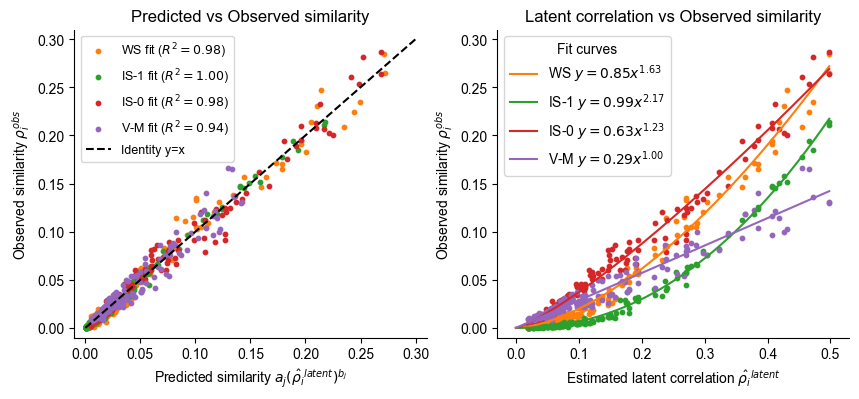

In [8]:
# Make a mosaic with
mosaic = """
AB
"""
fig, axes = plt.subplot_mosaic(mosaic, figsize=(10, 4))

ax = axes['A']
r_hat = pred_df.r_hat
pars_df_indexed = pars_df.set_index("measure")
for i, measure in enumerate(["ws_1", "is_1", "is_0", "vision"]):
    a, b, r2 = pars_df_indexed.loc[measure].a, pars_df_indexed.loc[measure].b, pars_df_indexed.loc[measure].R2_col
    
    m_name = measure_names[measure].replace('\n', ' ')
    ax.scatter(a * (r_hat ** b), df[mask][measure], label=f"{m_name} fit ($R^2={r2:.2f}$)", color=f"C{i+1}", s=10)

ax.plot([0, 0.3], [0, 0.3], color='black', linestyle='--', label='Identity y=x', zorder=100)
ax.set_ylabel(r"Observed similarity $\rho^{obs}_i$")
ax.set_xlabel(r"Predicted similarity ${a_j}(\hat{\rho_i}^{latent})^{b_j}$")
ax.legend(fontsize=9)
sns.despine(ax=ax)
ax.set_title("Predicted vs Observed similarity")




ax = axes['B']
r_hat_true = np.linspace(0, np.max(pred_df.r_hat), 1000)


for i, measure in enumerate(["ws_1", "is_1", "is_0", "vision"]):
    a, b, r2 = pars_df_indexed.loc[measure].a, pars_df_indexed.loc[measure].b, pars_df_indexed.loc[measure].R2_col
    
    m_name = measure_names[measure].replace('\n', ' ')
    y_fit = a * (r_hat_true ** b)
    ax.plot(r_hat_true, y_fit, label=f"{m_name} $y={a:.2f} x^{{{b:.2f}}}$", color=f"C{i+1}", zorder=100)

    # scatter of latent vs observed
    observed = df[mask][measure]
    ax.scatter(r_hat, observed, color=f"C{i+1}", s=10, alpha=1, zorder=50)

# ax.plot(r_hat_true, r_hat_true, color='black', linestyle='--', label='$\\hat{\\rho}^{latent}$ (y=x)')
ax.set_xlabel(r"Estimated latent correlation $\hat{\rho_i}^{latent}$")
ax.set_ylabel(r"Observed similarity $\rho^{obs}_i$")
ax.set_title("Latent correlation vs Observed similarity")
ax.legend(title="Fit curves")
sns.despine(ax=ax)

axes['A'].set_ylim(0-0.01, 0.3+0.01)
axes['A'].set_xlim(0-0.01, 0.3+0.01)
axes['B'].set_ylim(0-0.01, 0.3+0.01)
axes['B'].set_xlim(0-0.03, 0.5+0.03)

r_hats = pd.DataFrame(estimated_r_hats.T)
r_hats["roi"] = df[mask].roi.values
r_hats = r_hats.melt(id_vars=["roi"], var_name="initialization", value_name="r_hat")
r_hats = r_hats.sort_values("roi").reset_index(drop=True)
r_hats = r_hats.merge(hcp[["name", "roi", "mne_name"]], on="roi")
names = r_hats.groupby("name").r_hat.mean().nlargest(40).reset_index().name.tolist()

fig.savefig(output_folder / "01_prediction_model.pdf", bbox_inches='tight', transparent=True)

## 8. Latent estimate stability

We re‑fit with many random initialisations; show **violin plots** of $\hat\rho^{\text{latent}}_r$ across runs for top 40 parcels.

Takeaways:

- Rank ordering is extremely stable (narrow violins).  
- Peaks (~0.5) appear in EVC (VMV2, MST, V1/V2) and LOTC; ventral parcels (PHA/VMV) also high.  
- Variability is modest, indicating the optimisation’s scale indeterminacy does not affect conclusions.
- However, the problem is not fully identifiable, but always converges on solutions monotonically related.



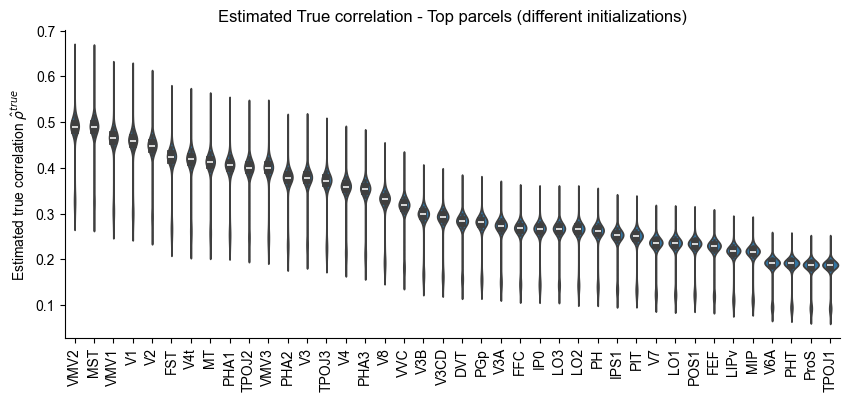

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
r_hats = pd.DataFrame(estimated_r_hats.T)
r_hats["roi"] = df[mask].roi.values
r_hats = r_hats.melt(id_vars=["roi"], var_name="initialization", value_name="r_hat")
r_hats = r_hats.sort_values("roi").reset_index(drop=True)
r_hats = r_hats.merge(hcp[["name", "roi", "mne_name"]], on="roi")
names = r_hats.groupby("name").r_hat.mean().nlargest(40).reset_index().name.tolist()

#sns.boxenplot(data=r_hats.query("name in @names"), x="name", y="r_hat", order=names, showfliers=False, ax=ax)
sns.violinplot(data=r_hats.query("name in @names"), x="name", y="r_hat", order=names, ax=ax)
sns.despine(ax=ax)
ax.set_xlabel("")
ax.set_ylabel(r"Estimated true correlation $\hat{\rho}^{true}$")
ax.set_title("Estimated True correlation - Top parcels (different initializations)")
# Set xtick labels to be vertical
# Set ticks firsts
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center');
fig.savefig(output_folder / "02_estimated_r_distribution_top_parcels.pdf", bbox_inches='tight', transparent=True)

## 9. Pairwise relations

For the 4 core metrics:

- Grey dots: empirical parcel scatter.  
- **Red solid**: independent power‑law fit per scatter.  
- **Black dashed**: *no new fit*—relation predicted by Eq. S2 using the joint parameters.  

High overlap confirms a single latent $\hat\rho$ + per‑metric $(a_j,b_j)$ explains all pairwise curves.


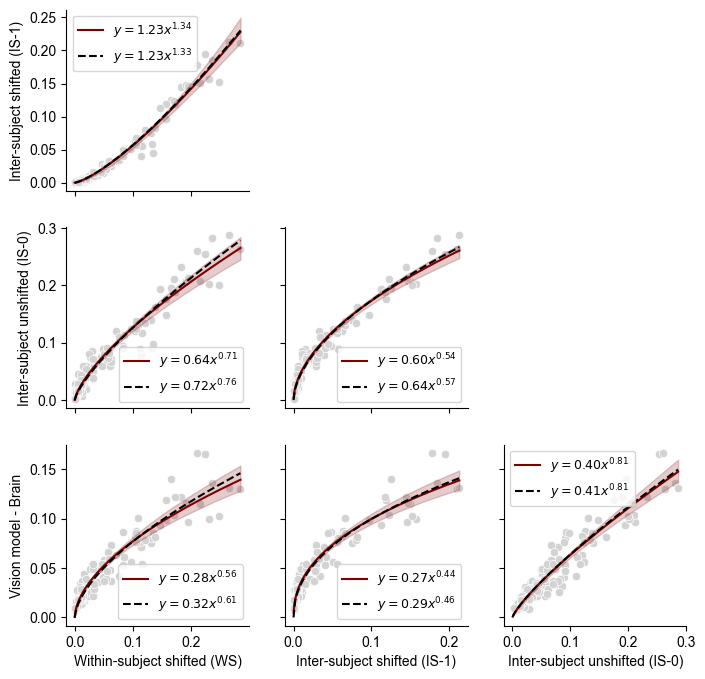

In [10]:
cols = ['ws_1', 'is_1', 'is_0', 'vision']
long_names = {
    "ws_1": "Within-subject shifted (WS)",
    "is_1": "Inter-subject shifted (IS-1)",
    "is_0": "Inter-subject unshifted (IS-0)",
    "vision": "Vision model - Brain"
}

fig, axes = plot_vars(df[mask][cols], filename_hcp=filename_hcp,df_params=pars_df.set_index("measure"), figsize=(8, 8), names=long_names)
fig.savefig(output_folder / "03_adjust_latent_correlation_4_variables.pdf", bbox_inches='tight', transparent=True)

## 10. Latent cortical map

Median $\hat\rho^{\text{latent}}_r$ (across restarts) projected onto fsaverage:

- Three hubs emerge: **EVC**, **ventral temporal**, **LOTC**.  
- **pFC/FEF** increase relative to raw metrics—once attenuation is removed, their latent similarity is clearer.  
- Colorbar: 0–0.5 (PiYG/RdBu depending on choice); we used RdBu_r symmetric for visualization, but note latent values are ≥0.

Multiple views saved (lateral/medial/ventral/rostral/dorsal/caudal).


In [11]:
brain_folder = output_folder / "04_brain_latent_correlation"
brain_folder.mkdir(exist_ok=True, parents=True)

r_hats_median = r_hats.groupby("mne_name").r_hat.median().reset_index()
views = ["lateral", "medial", "ventral", "dorsal", "caudal"]
r_max = 0.5 # r_hats_median.r_hat.max().round(1) # 0.50. rmin=0

brain = plot_faverage_parcelation(r_hats_median[["r_hat", "mne_name"]], value_column="r_hat", normalize=(-r_max, r_max), cmap="RdBu_r", default_value=None, default_color="lightgray", hemisphere="lh")
for view in views:
    brain.show_view(view)
    brain.save_image(brain_folder / f"04_ceiling_analysis_{view}_{r_max:.1f}.png", mode="rgba")
brain.close()

Inspect the brain maps with the estimated latent correlations.

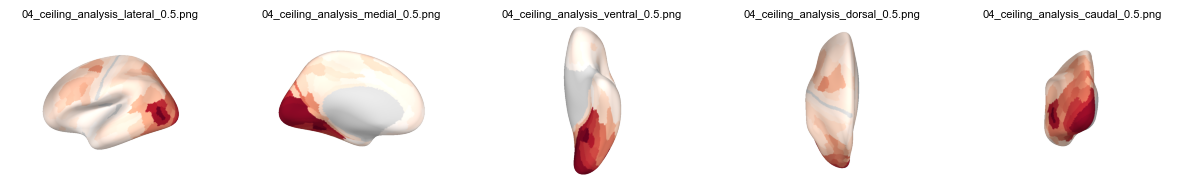

In [12]:
fig, axes = plt.subplots(1, len(views), figsize=(len(views) * 3, 3))
for i, view in enumerate(views):
    ax = axes[i]
    filename = brain_folder / f"04_ceiling_analysis_{view}_{r_max:.1f}.png"
    img = plt.imread(filename)
    ax.imshow(img)
    ax.set_title(filename.name, fontsize=8)
    ax.axis('off')

## 12. Colorbar for latent map

Standalone colorbar (0–0.5) for manuscript assembly.


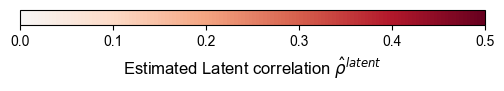

In [13]:
title = "Estimated Latent correlation $\hat{\\rho}^{latent}$"
filename = output_folder/ f"04_colorbar_model_{r_max:.2f}_BuRd.pdf"
plot_cbar_set(title=title, filename=filename, vmin=0, vmax=r_max, locator=0.1)

Repeat model fit with all loaded measurements

In [14]:
df = pd.DataFrame(
    {
        "roi": df_is_1.roi,
        "ws_1": df_ws_1.similarity.values,
        "ws_1_left": df_ws_1_left.similarity.values,
        "ws_1_right": df_ws_1_right.similarity.values,
        "is_0": df_is_0.similarity.values,
        "is_0_left": df_is_0_left.similarity.values,
        "is_0_right": df_is_0_right.similarity.values,
        "group_0": df_group_0.similarity.values,
         "is_1": df_is_1.similarity.values,
        "is_1_left": df_is_1_left.similarity.values,
        "is_1_right": df_is_1_right.similarity.values,
        "group_1": df_group_1.similarity.values,
        "vision": vision_models.similarity.values,
    }
)

mask = df.min(axis=1) > 0
pars_df, pred_df, estimated_r_hats = fit_power_ceiling(
    df[mask].drop(columns="roi"),
    b_bounds=(1, None),
    a_bounds=(0, 1),
    verbose=False,
    n_restart=1000,
    intercept=False,
)
pred_df["roi"] = df[mask].roi.values
hcp = pd.read_csv(filename_hcp)
pred_df = pred_df.merge(hcp[["roi", "name", "mne_name"]], on="roi", how="left")
r_hat = pred_df.r_hat

Plot the pairwise relations for all metrics. The model captures the trend of all measures at the same time, showing how they relate to each other.

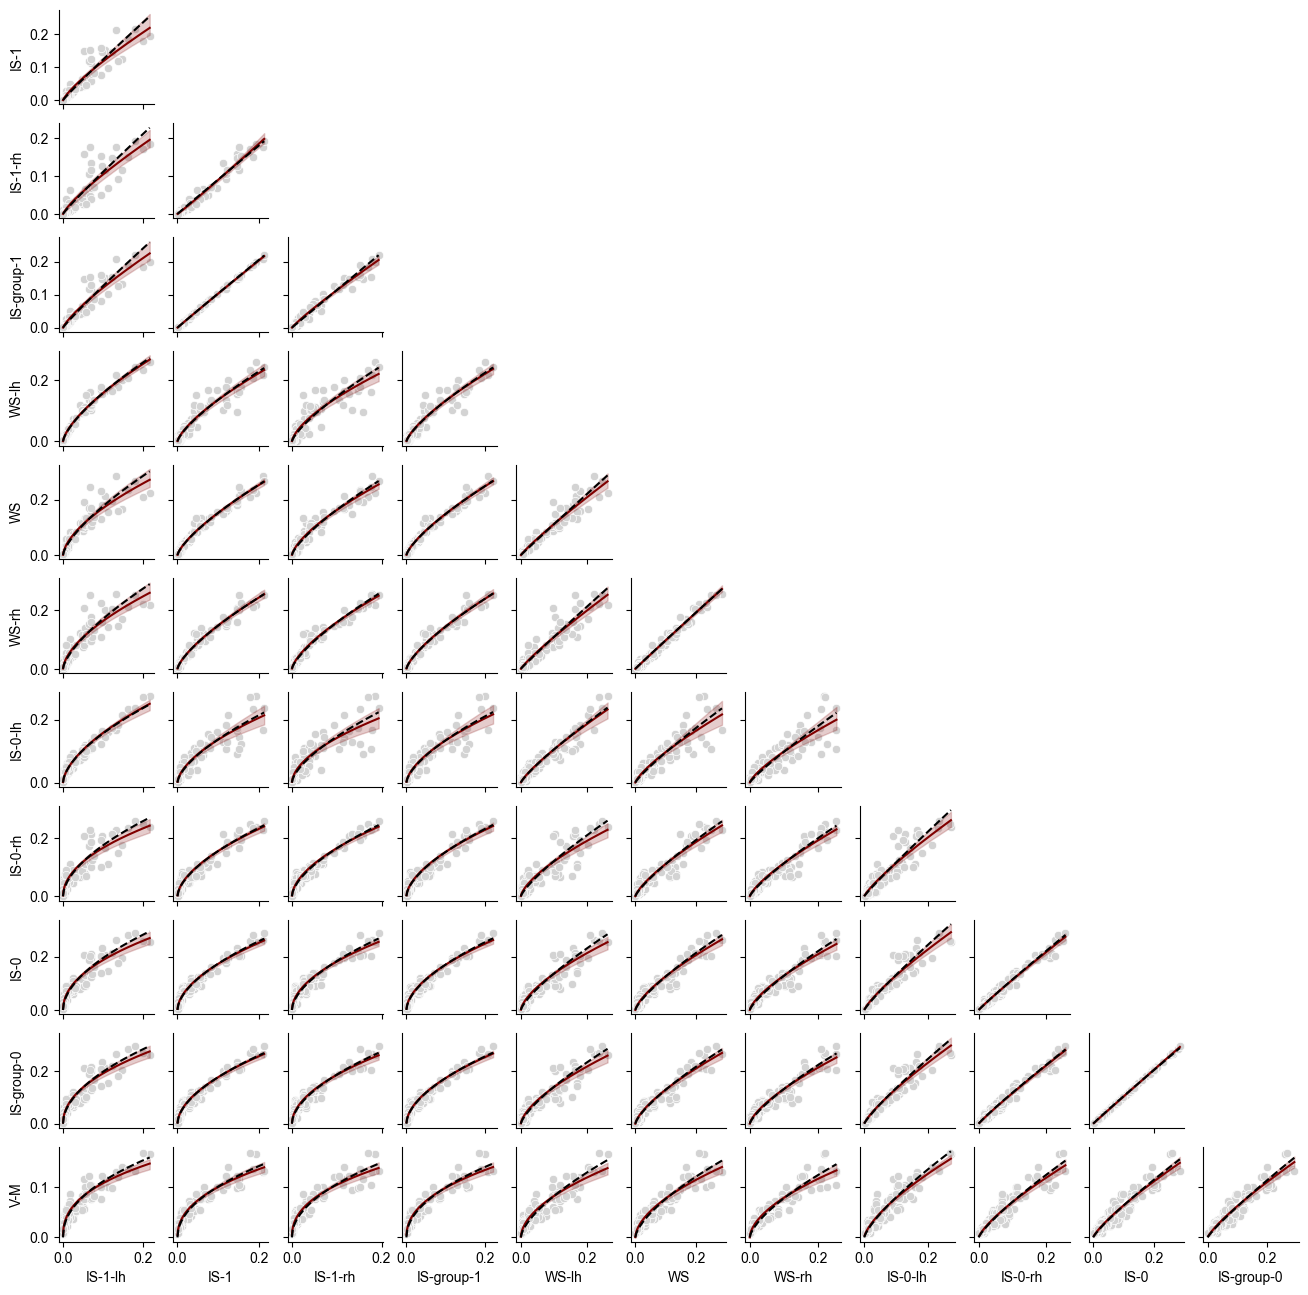

In [15]:
cols = pars_df.sort_values("b", ascending=False).measure.tolist()
fig, axes = plot_vars(df[mask][cols], filename_hcp=filename_hcp, df_params=pars_df.set_index("measure"), figsize=(16, 16), names=measure_names)

# Remove all legends
for ax in axes.flat:
    if ax.legend_ is not None:
        ax.legend_.remove()
fig.savefig(output_folder / "05_ceiling_analysis_vars_extended.pdf", bbox_inches='tight', transparent=True)

Print a table with the estimated parameters for each metric in the fit.

In [16]:
pars_df_formatted = pars_df.sort_values("b", ascending=False).drop(columns="d")
pars_df_formatted.measure = pars_df_formatted.measure.map(measure_names)
pars_df_formatted.a = pars_df_formatted.a.round(2).astype(str)
pars_df_formatted.b = pars_df_formatted.b.round(2).astype(str)
pars_df_formatted.R2_col = pars_df_formatted.R2_col.round(2).astype(str)
pars_df_formatted = pars_df_formatted.rename(columns={"measure": "Measure", "a": "$a_j$", "b": "$b_j$", "R2_col": "$R^2$"})

print(pars_df_formatted.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Measure & $a_j$ & $b_j$ & $R^2$ \\
\midrule
IS-1-lh & 0.91 & 2.17 & 0.92 \\
IS-1 & 0.98 & 2.05 & 0.99 \\
IS-1-rh & 0.87 & 2.03 & 0.96 \\
IS-group-1 & 0.99 & 2.02 & 0.99 \\
WS-lh & 0.76 & 1.54 & 0.95 \\
WS & 0.82 & 1.51 & 0.97 \\
WS-rh & 0.77 & 1.49 & 0.97 \\
IS-0-lh & 0.59 & 1.31 & 0.92 \\
IS-0-rh & 0.61 & 1.22 & 0.96 \\
IS-0 & 0.64 & 1.17 & 0.98 \\
IS-group-0 & 0.62 & 1.13 & 0.98 \\
V-M & 0.31 & 1.0 & 0.94 \\
\bottomrule
\end{tabular}



## 13. Key conclusions

- **Single latent geometry**: All RSA variants are consistent with one underlying similarity map; differences are pure attenuation.  
- **Noise structure**: Metrics differ not just in scale (a) but also slope (b): weak parcels are disproportionately damped in noisier measures.  
- **Model invariance**: Pairwise relations emerge analytically (Eq. S2); no need to fit each scatter separately.  
- **Latent hubs**: Same three-hub architecture as raw metrics, plus clearer frontal involvement after denoising.

These results motivate reporting latent estimates when comparing across metrics, while raw values remain useful to visualise metric-specific reliability.
